In [34]:
import collections
import hashlib
import math
import os
import random
import re
import shutil
import sys
import tarfile
import time
import zipfile
from collections import defaultdict
import pandas as pd
import requests
from IPython import display
from matplotlib import pyplot as plt
from torch.utils import data
import torch
from Bio import SeqIO
import matplotlib_inline
import numpy as np

In [35]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

def tokenize_BioSeq(seqs,token = 'k-mers',k = 6):
    """将生物序列拆分为单词或直k个连续的单元（碱基或氨基酸）"""
    if token == 'char':
        return[list(seq) for seq in seqs]
    if token == 'k-mers':
        seqlist = []
        for seq in seqs:
            kmers = []
            for a in range(len(seq)-k+1):
                kmer = seq[a:a+k]
                kmers.append(kmer)
            seqlist.append(kmers)
        return(seqlist)
    else:
        print("错误，未知类型"+token)
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            #保留字，用于序列补齐
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs
    
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

In [36]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [37]:
#获取GPU
def try_all_gpus():
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]

    Defined in :numref:`sec_use_gpu`"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

In [38]:
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [39]:
#绘图
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点

    Defined in :numref:`sec_calculus`"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
def set_figsize(figsize=(3.5, 2.5)):
    """设置matplotlib的图表大小

    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
def use_svg_display():
    """使用svg格式在Jupyter中显示绘图

    Defined in :numref:`sec_calculus`"""
    #display.set_matplotlib_formats('svg')
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


In [40]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器

    Defined in :numref:`sec_linear_concise`"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

def load_protein_data(data_dir,batch_size, num_steps=500):
    data,label = [],[]
    positive_record_iter = SeqIO.parse(data_dir+"positive_training.fasta","fasta")
    negatine_record_iter = SeqIO.parse(data_dir+"negative_training.fasta","fasta")
    for pt_seq in positive_record_iter:
        data.append(str(pt_seq.seq))
        label.append(1)
    for pt_seq in negatine_record_iter:
        data.append(str(pt_seq.seq))
        label.append(0)
    df = pd.DataFrame({'seq':data,'label':label})
    df = df.sample(frac=1)
    train_data = df.sample(frac=0.8,random_state=0,axis=0)
    test_data = df[~df.index.isin(train_data.index)]

    train_tokens = tokenize(list(train_data['seq']),token='char')
    test_tokens = tokenize(list(test_data['seq']),token='char')

    vocab = Vocab(train_tokens,min_freq=0)
    train_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['#']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['#']) for line in test_tokens])
    train_iter = load_array((train_features, torch.tensor(list(train_data['label']))),
                                batch_size)
    test_iter = load_array((test_features, torch.tensor(list(test_data['label']))),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

def load_protein_csv_data(data_dir,batch_size, num_steps=500):
    positive_df = pd.read_csv(data_dir+"Halophilic_protein.csv")
    negatine_df = pd.read_csv(data_dir+"No_Halophilic_protein.csv")

    df = positive_df.append(negatine_df)
    df = df.sample(frac=1)
    train_data = df.sample(frac=0.8,random_state=0,axis=0)
    test_data = df[~df.index.isin(train_data.index)]

    train_tokens = tokenize(list(train_data['sequence']),token='k-mers',k=3)
    test_tokens = tokenize(list(test_data['sequence']),token='k-mers',k=3)

    vocab = Vocab(train_tokens,min_freq=0)
    train_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['#']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['#']) for line in test_tokens])
    train_iter = load_array((train_features, torch.tensor(list(train_data['label']))),
                                batch_size)
    test_iter = load_array((test_features, torch.tensor(list(test_data['label']))),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

In [41]:
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F

def load_LLPS_data(batch_size,num_steps = 300):
    data,label = [],[]
    
    df1 = pd.read_excel('../data/LLPS/DeePhase/pnas.2019053118.sd01.xlsx')
    df4 = pd.read_excel('../data/LLPS/DeePhase/pnas.2019053118.sd04.xlsx')
    
    df1.rename(columns={'Dataset S1. LLPS+ (high LLPS-propensity sequences).':'seq'},inplace=True)
    df4.rename(columns={'Dataset S4. Subset of PDB* used for training.':'seq'},inplace=True)
    
    df1_labels = [1]*len(df1)
    df4_labels = [0]*len(df4)

    df = pd.DataFrame({'seq':list(df1['seq'])+list(df4['seq']),'label':df1_labels+df4_labels})
    print(df)
    df = df.sample(frac=1)
    train_data = df.sample(frac=0.8,random_state=0,axis=0)
    test_data = df[~df.index.isin(train_data.index)]

    train_tokens = tokenize(list(train_data['seq']),token='char')
    test_tokens = tokenize(list(test_data['seq']),token='char')

    vocab = Vocab(train_tokens,min_freq=0)
    train_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = load_array((train_features, torch.tensor(list(train_data['label']))),
                                batch_size)
    test_iter = load_array((test_features, torch.tensor(list(test_data['label']))),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab


                                                   seq  label
0    SMGNAVPGMNPAMGMNMGGMMGFPMGGPSASPNPMMNGFAAGSMGM...      1
1    MENSQLCKLFIGGLNVQTSESGLRGHFEAFGTLTDCVVVVNPQTKR...      1
2    MGRPEFNRGGGGGGFRGGRGGDRGGSRGGFGGGGRGGYGGGDRGSF...      1
3    ASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDT...      1
4    MPLNVSFTNRNYDLDYDSVQPYFYCDEEENFYQQQQQSELQPPAPS...      1
..                                                 ...    ...
269  MVKYQYEFPLDKAGKAGAVKPYRGGKNDFVTPVSNLSGVAEILTNA...      0
270  MLLEAIFHEAKGSYAYPISETQLRVRLRAKKGDVVRCEVLYADRYA...      0
271  ASEDGGRGPYVQADLAYAYEHITHDYPEPTAPNKNKISTVSDYFRN...      0
272  MKYDLIIIGSGSVGAAAGYYATRAGLNVLMTDAHMPPHQHGSHHGD...      0
273  QAVQPVDFRHHHFSDMEIFLRRYANEYPSITRLYSVGKSVELRELY...      0

[274 rows x 2 columns]


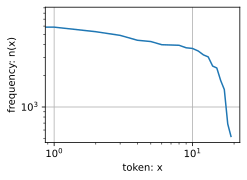

In [42]:
train_iter, test_iter, vocab = load_LLPS_data(batch_size = 16)
freqs = [freq for token, freq in vocab.token_freqs]
plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')
         

In [43]:
for x,y in train_iter:
    print(x)
    break

tensor([[17, 10,  3,  ..., 13,  9,  2],
        [17,  6, 14,  ...,  0,  0,  0],
        [17,  3,  6,  ...,  2,  2,  2],
        ...,
        [17,  1,  7,  ...,  0,  0,  0],
        [17, 16, 13,  ..., 16,  9,  2],
        [17, 10,  1,  ...,  0,  0,  0]])


In [44]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embedding_dim, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [45]:
class BiRNN_Attention(nn.Module):
    def __init__(self, config, **kwargs):
        super(BiRNN_Attention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.GRU(config.embedding_dim, config.num_hiddens, num_layers=config.num_layers,
                                bidirectional=True)
        self.drop = nn.Dropout(p = 0.2)
        self.tanh = nn.Tanh()
        #注意力层
        self.w = nn.Linear(config.num_hiddens*2, config.num_hiddens*2)
        #全连接层
        self.fc1 = nn.Linear(config.num_hiddens*2, config.num_hiddens)
        self.fc = nn.Linear(config.num_hiddens, config.label_num)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        outputs = outputs.permute(1, 0, 2)
        # 添加激活函数
        #outputs = self.tanh(outputs)
        # 初始化注意力权重矩阵
        # alpha 的形状是(批量大小，时间步数，2*隐藏单元数)
        alpha = self.w(outputs)
        # 按第1个维度做softmax运算，从而得到每个词向量的注意力权重
        # alpha 的形状是(批量大小，时间步数，2*隐藏单元数)，但此时得到了每一个句子的注意力权重
        alpha = F.softmax(alpha,dim = 1)
        # ’*‘操作又称作 “哈达玛积”, 简单来说就是 tensor 元素逐个相乘
        out = outputs*alpha
        # 对每个句子经行全局汇聚，结果就是隐状态表示句子
        out = torch.sum(out, 1)
        # 添加激活函数
        #out = self.tanh(out)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.tanh(out)
        out = self.fc(out)
        return out

In [46]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim,num_steps, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.fc1 = nn.Linear(embedding_dim,1)
        self.fc2 = nn.Linear(num_steps,2)

    def forward(self, x):
        #print(x.shape)
        embed_x = self.embedding(x)
        #print(x.shape)
        x = self.fc1(embed_x)
        x = x.squeeze()
        #x = embed_x.reshape(embed_x.shape[0],-1)
        y = self.fc2(x)
        return y

In [47]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

def corr1d_multi_in(X, K):
    # 首先，遍历'X'和'K'的第0维（通道维）。然后，把它们加在一起
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # 这个嵌入层不需要训练
        self.constant_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # 最大时间汇聚层没有参数，因此可以共享此实例
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embedding_dim, c, k))

    def forward(self, inputs):
        # 沿着向量维度将两个嵌入层连结起来，
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）连结起来
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        embeddings = embeddings.permute(0, 2, 1)
        # 每个一维卷积层在最大时间汇聚层合并后，获得的张量形状是（批量大小，通道数，1）
        # 删除最后一个维度并沿通道维度连结
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [48]:
def get_net(tp):
    if(tp == "CNN"):
        embedding_dim, kernel_sizes, nums_channels = 200, [3, 4, 5], [128, 128, 128]
        devices = try_all_gpus()
        net = TextCNN(len(vocab), embedding_dim, kernel_sizes, nums_channels)
        def init_weights(m):
            if type(m) in (nn.Linear, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
        net.apply(init_weights);
        return net
    elif(tp == "RNN"):
        embedding_dim, num_hiddens, num_layers = 64, 64, 2
        devices = try_all_gpus()
        net = BiRNN(len(vocab), embedding_dim, num_hiddens, num_layers)
        def init_weights(m):
            if type(m) == nn.Linear:
                nn.init.xavier_uniform_(m.weight)
            if type(m) == nn.LSTM:
                for param in m._flat_weights_names:
                    if "weight" in param:
                        nn.init.xavier_uniform_(m._parameters[param])
        net.apply(init_weights);
    elif(tp=='MLP'):
        vocab_size, embedding_dim,num_steps= len(vocab),100,500
        net = MLP(vocab_size, embedding_dim,num_steps)
        def init_weights(m):
            if type(m) == nn.Linear:
                nn.init.xavier_uniform_(m.weight)
        net.apply(init_weights);
    elif(tp == 'RNN-Att'):
        class config:
            vocab_size  = len(vocab)
            num_layers  = 1
            embedding_dim  = 128
            num_hiddens = 128
            label_num   = 2
        net = BiRNN_Attention(config)
        def init_weights(m):
            if type(m) == nn.Linear:
                nn.init.xavier_uniform_(m.weight)
            if type(m) == nn.GRU:
                for param in m._flat_weights_names:
                    if "weight" in param:
                        nn.init.xavier_uniform_(m._parameters[param])
        net.apply(init_weights);  
    return net

In [49]:
class TokenEmbedding:
    """特征嵌入"""
    def __init__(self, embedding_name = 'PAAC'):
        """Defined in :numref:`sec_synonyms`"""
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        PAAC = pd.read_csv(embedding_name+'.txt',sep = '\t',index_col=False)
        idx_to_token, idx_to_vec = ['<unk>'], []    
        idx_to_token = idx_to_token+list(PAAC.columns)[1:]
        for aa in list(PAAC.columns)[1:]:
            idx_to_vec.append(list(PAAC[aa]))
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        
        return idx_to_token, torch.tensor(idx_to_vec)
    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [50]:
def train_batch(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练

    Defined in :numref:`sec_image_augmentation`"""
    if isinstance(X, list):
        # 微调BERT中所需（稍后讨论）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [51]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=try_all_gpus()):
    """用多GPU进行模型训练

    Defined in :numref:`sec_image_augmentation`"""
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [52]:
zscale = {
    'A': [0.24, -2.32, 0.60, -0.14, 1.30],  # A
    'C': [0.84, -1.67, 3.71, 0.18, -2.65],  # C
    'D': [3.98, 0.93, 1.93, -2.46, 0.75],  # D
    'E': [3.11, 0.26, -0.11, -0.34, -0.25],  # E
    'F': [-4.22, 1.94, 1.06, 0.54, -0.62],  # F
    'G': [2.05, -4.06, 0.36, -0.82, -0.38],  # G
    'H': [2.47, 1.95, 0.26, 3.90, 0.09],  # H
    'I': [-3.89, -1.73, -1.71, -0.84, 0.26],  # I
    'K': [2.29, 0.89, -2.49, 1.49, 0.31],  # K
    'L': [-4.28, -1.30, -1.49, -0.72, 0.84],  # L
    'M': [-2.85, -0.22, 0.47, 1.94, -0.98],  # M
    'N': [3.05, 1.62, 1.04, -1.15, 1.61],  # N
    'P': [-1.66, 0.27, 1.84, 0.70, 2.00],  # P
    'Q': [1.75, 0.50, -1.44, -1.34, 0.66],  # Q
    'R': [3.52, 2.50, -3.50, 1.99, -0.17],  # R
    'S': [2.39, -1.07, 1.15, -1.39, 0.67],  # S
    'T': [0.75, -2.18, -1.12, -1.46, -0.40],  # T
    'V': [-2.59, -2.64, -1.54, -0.85, -0.02],  # V
    'W': [-4.36, 3.94, 0.59, 3.44, -1.59],  # W
    'Y': [-2.54, 2.44, 0.43, 0.04, -1.47],  # Y
    '-': [0.00, 0.00, 0.00, 0.00, 0.00],  # -
}
blosum62 = {
    'A': [4, -1, -2, -2, 0, -1, -1, 0, -2, -1, -1, -1, -1, -2, -1, 1, 0, -3, -2, 0],  # A
    'R': [-1, 5, 0, -2, -3, 1, 0, -2, 0, -3, -2, 2, -1, -3, -2, -1, -1, -3, -2, -3],  # R
    'N': [-2, 0, 6, 1, -3, 0, 0, 0, 1, -3, -3, 0, -2, -3, -2, 1, 0, -4, -2, -3],  # N
    'D': [-2, -2, 1, 6, -3, 0, 2, -1, -1, -3, -4, -1, -3, -3, -1, 0, -1, -4, -3, -3],  # D
    'C': [0, -3, -3, -3, 9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1],  # C
    'Q': [-1, 1, 0, 0, -3, 5, 2, -2, 0, -3, -2, 1, 0, -3, -1, 0, -1, -2, -1, -2],  # Q
    'E': [-1, 0, 0, 2, -4, 2, 5, -2, 0, -3, -3, 1, -2, -3, -1, 0, -1, -3, -2, -2],  # E
    'G': [0, -2, 0, -1, -3, -2, -2, 6, -2, -4, -4, -2, -3, -3, -2, 0, -2, -2, -3, -3],  # G
    'H': [-2, 0, 1, -1, -3, 0, 0, -2, 8, -3, -3, -1, -2, -1, -2, -1, -2, -2, 2, -3],  # H
    'I': [-1, -3, -3, -3, -1, -3, -3, -4, -3, 4, 2, -3, 1, 0, -3, -2, -1, -3, -1, 3],  # I
    'L': [-1, -2, -3, -4, -1, -2, -3, -4, -3, 2, 4, -2, 2, 0, -3, -2, -1, -2, -1, 1],  # L
    'K': [-1, 2, 0, -1, -3, 1, 1, -2, -1, -3, -2, 5, -1, -3, -1, 0, -1, -3, -2, -2],  # K
    'M': [-1, -1, -2, -3, -1, 0, -2, -3, -2, 1, 2, -1, 5, 0, -2, -1, -1, -1, -1, 1],  # M
    'F': [-2, -3, -3, -3, -2, -3, -3, -3, -1, 0, 0, -3, 0, 6, -4, -2, -2, 1, 3, -1],  # F
    'P': [-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4, 7, -1, -1, -4, -3, -2],  # P
    'S': [1, -1, 1, 0, -1, 0, 0, 0, -1, -2, -2, 0, -1, -2, -1, 4, 1, -3, -2, -2],  # S
    'T': [0, -1, 0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1, 1, 5, -2, -2, 0],  # T
    'W': [-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1, 1, -4, -3, -2, 11, 2, -3],  # W
    'Y': [-2, -2, -2, -3, -2, -1, -2, -3, 2, -1, -1, -2, -1, 3, -3, -2, -2, 2, 7, -1],  # Y
    'V': [0, -3, -3, -3, -1, -2, -2, -3, -3, 3, 1, -2, 1, -1, -2, -2, 0, -3, -1, 4],  # V
    '-': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # -
}

class TokenEmbeddingDict:
    """特征嵌入"""
    def __init__(self, embedding_name):
        """Defined in :numref:`sec_synonyms`"""
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        PAAC = pd.DataFrame.from_dict(embedding_name)
        idx_to_token, idx_to_vec = ['<unk>'], []    
        idx_to_token = idx_to_token+list(PAAC.columns)[1:]
        for aa in list(PAAC.columns)[1:]:
            idx_to_vec.append(list(PAAC[aa]))
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        
        return idx_to_token, torch.tensor(idx_to_vec)
    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [53]:
class ResnetBlock(nn.Module):
    
    def __init__(self, channel_size):
        super(ResnetBlock, self).__init__()

        self.channel_size = channel_size
        self.maxpool = nn.Sequential(
            nn.ConstantPad1d(padding=(0, 1), value=0), # 使用常量来填充输入张量的边界，padding - 填充的数量，value - 要填充的值
            nn.MaxPool1d(kernel_size=3, stride=2)
        )
        self.conv = nn.Sequential( #一个1/2池化的残差块
            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(),
            nn.Conv1d(self.channel_size, self.channel_size, kernel_size=3, padding=1),

            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(),
            nn.Conv1d(self.channel_size, self.channel_size, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x_shortcut = self.maxpool(x)
        x = self.conv(x_shortcut)
        x = x + x_shortcut
        return x

class TextCNNHyperparameters:
    def __init__(self, vocab_size=22, embedding_dim=64, max_length=300,
                 num_filters=64, kernel_size=3, hidden_dim=64,num_classes = 2):
        self.vocab_size = vocab_size # 词汇表大小
        self.embedding_dim = embedding_dim # 嵌入层大小
        self.blosum62_dim = 20
        self.max_length = max_length # 序列最大长度
        self.num_filters = num_filters # 卷积核数量
        self.kernel_size = kernel_size # 卷积核大小
        self.hidden_dim = hidden_dim # 全连接层大小
        self.num_classes = num_classes
    
hparams = TextCNNHyperparameters()    
class DPCNN(nn.Module):
    def __init__(self, hparams,
                 **kwargs):
        super(DPCNN, self).__init__(**kwargs)
        
        self.embedding = nn.Embedding(hparams.vocab_size, hparams.embedding_dim)
        
        # 这个嵌入层不需要训练
        self.constant_embedding = nn.Embedding(hparams.vocab_size, hparams.blosum62_dim)
        
        self.max_features = hparams.vocab_size #  词典的大小尺寸
        self.embedding_dim = hparams.blosum62_dim + hparams.embedding_dim #  嵌入向量的维度，即用多少维来表示一个符号，300
        self.maxlen = hparams.max_length # 训练样本中最大的词数 300
        self.num_classes = hparams.num_classes # 分类数
        self.channel_size = hparams.num_filters
        self.kernel_size = hparams.kernel_size
        
        self.dropout = nn.Dropout(0.5)

        # 一、region embedding
        # 将普通的word embedding转换成能够覆盖一个或多个词的region embedding
        self.region_embedding = nn.Sequential(
            # 限制输出词向量维度为250，卷积核大小3，padding=1表示填一个0
            nn.Conv1d(self.embedding_dim, self.channel_size, kernel_size=self.kernel_size, padding=1),
            # BatchNorm在深度神经网络训练过程中使得每一层神经网络的输入保持相同分布
            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        # 二、经过两层等长卷积，为特征抽取提供更宽的感受眼，提高embdding的丰富性
        self.conv_block = nn.Sequential(
            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(),
            nn.Conv1d(self.channel_size, self.channel_size, kernel_size = self.kernel_size, padding=1), # 在卷一次
            nn.BatchNorm1d(num_features=self.channel_size),
            nn.ReLU(),
            nn.Conv1d(self.channel_size, self.channel_size, kernel_size = self.kernel_size, padding=1), # 卷第二次
        )
        

        #  三、Downsampling（1/2池化）
        self.seq_len = self.maxlen
        resnet_block_list = []
        while (self.seq_len > 2):
            resnet_block_list.append(ResnetBlock(self.channel_size))
            self.seq_len = self.seq_len // 2  # 二分之一池化，减少词向量维度，提高每个神经元包含的语义

        # 四、构建pre-activation，近路连接
        self.resnet_layer = nn.Sequential(*resnet_block_list)
        
        # 五、全连接层
        self.fc = nn.Sequential(
            nn.Linear(self.channel_size * self.seq_len, self.num_classes),
            nn.BatchNorm1d(self.num_classes),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(self.num_classes, self.num_classes)
        )
    def forward(self, inputs):
        # 沿着向量维度将两个嵌入层连结起来，
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）连结起来
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        #print(embeddings.shape)

        x = embeddings.permute(0, 2, 1) # 交换维度：[batch_size, embedding_dim, max_len]
        x = self.region_embedding(x)
        x = self.conv_block(x)
        x = self.resnet_layer(x) # 
        x = x.permute(0, 2, 1)
        x = x.contiguous().view(x.size(0), -1)
        output = self.fc(x)
        return output

    # def predict(self, description_word_seq):
    #     """
    #     :param description_word_seq: torch.LongTensor
    #     :返回 predict: dict of torch.LongTensor
    #     """
    #     output = self(description_word_seq)
    #     _, predict = output['output'].max(dim=1)
        
    #     return {'predict': predict}

   

In [54]:

devices = try_all_gpus()
# net = DPCNN(hparams)
# def init_weights(m):
#     if type(m) in (nn.Linear, nn.Conv1d):
#         nn.init.xavier_uniform_(m.weight)
# net.apply(init_weights);

# embeds = TokenEmbeddingDict(blosum62)[vocab.idx_to_token]
# net.constant_embedding.weight.data.copy_(embeds)
# net.constant_embedding.weight.requires_grad = False

In [59]:
net = get_net("RNN-Att")

loss 0.001, train acc 1.000, test acc 0.927
322.8 examples/sec on [device(type='cuda', index=0)]


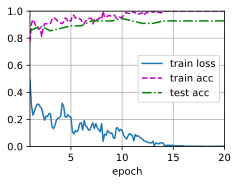

In [60]:
lr, num_epochs,wd= 0.001, 20, 0.001

#net = model_BERT
net.train()
devices = try_all_gpus()
trainer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay = wd)#
loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)